In [1]:
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
from scipy.optimize import minimize

In [3]:
def get_time_window(arDays = 180):
    today = datetime.today() 
    prev = (today - timedelta(days=arDays)) 
    today = today.strftime('%Y-%m-%d')
    prev = prev.strftime('%Y-%m-%d')
    return(prev, today)

In [4]:
(start, end) = get_time_window(arDays=1800)
stock_names = ['VOO','IVOO','VIOO','VEU','VWO','VNQ','BND']
voo, ivoo, vioo, veu, vwo, vnq, bnd = [web.DataReader(stock_name, 'iex', start, end) for stock_name in stock_names]
voo.head()

,open,high,low,close,volume
date,,,,,
2014-06-02,159.8952,159.9132,159.0940,159.8590,1620184
2014-06-03,159.4611,159.8551,159.3436,159.7595,1252941
2014-06-04,159.4792,160.1845,159.3255,160.0489,985004
2014-06-05,160.2659,161.2967,159.7143,161.1340,853687
2014-06-06,161.5137,161.9387,161.4233,161.9026,586821


# Portfolio Optimization

Text(0.5, 1.0, 'Closing Price')

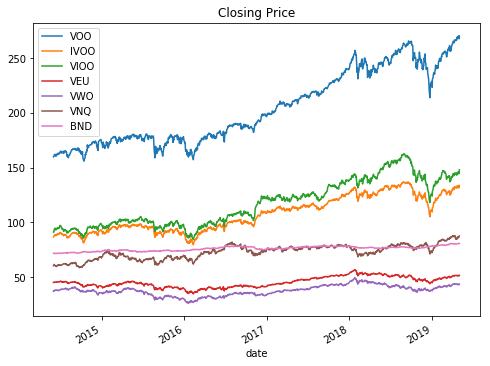

In [5]:
closing = pd.concat([stock['close']  for stock in [voo,ivoo,vioo,veu,vwo,vnq,bnd]],axis = 1)
closing.columns = stock_names
closing.index = pd.to_datetime(closing.index) 
closing.plot(figsize=(8,6))
plt.title("Closing Price")

Text(0.5, 1.0, 'Mean: Percent Daily Change')

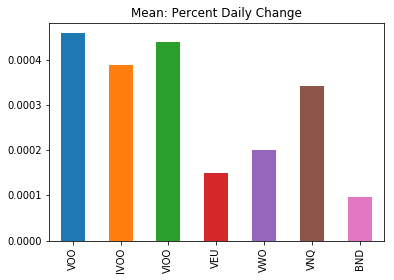

In [6]:
closing.pct_change(1).mean().plot(kind = 'bar')
plt.title("Mean: Percent Daily Change")

Text(0.5, 1.0, 'Standard Deviation: Percent Daily Change')

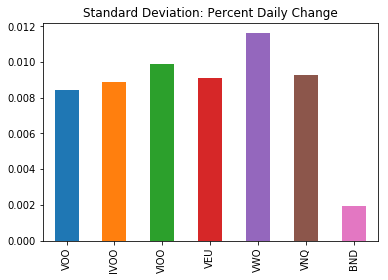

In [7]:
closing.pct_change(1).std().plot(kind = 'bar')
plt.title("Standard Deviation: Percent Daily Change")

Text(0.5, 1.0, 'Mean / Standard Deviation: Percent Daily Change')

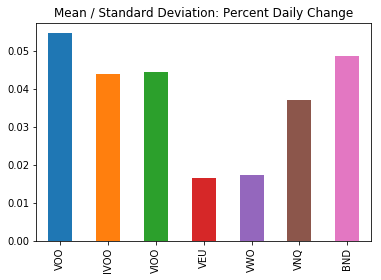

In [8]:
(closing.pct_change(1).mean()/closing.pct_change(1).std()).plot(kind = 'bar')
plt.title("Mean / Standard Deviation: Percent Daily Change")

Text(0.5, 1.0, 'Box Plot: Percent Daily Change')

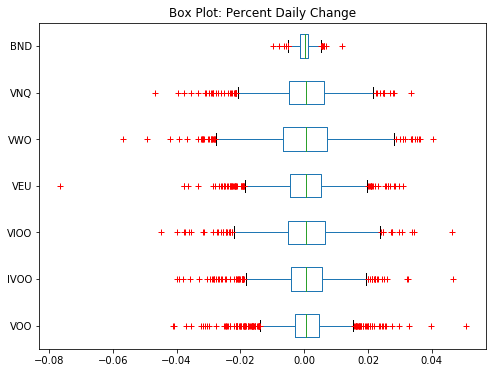

In [9]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
closing.pct_change(1).plot(kind = 'box', sym='r+', vert=False, figsize = (8,6))
plt.title("Box Plot: Percent Daily Change")

In [10]:
closing.pct_change(1).describe()

,VOO,IVOO,VIOO,VEU,VWO,VNQ,BND
count,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000
mean,0.000459,0.000388,0.000440,0.000151,0.000200,0.000343,0.000095
std,0.008413,0.008881,0.009916,0.009084,0.011607,0.009277,0.001963
min,-0.041076,-0.039733,-0.044921,-0.076614,-0.056636,-0.046815,-0.009889
25%,-0.002810,-0.004179,-0.005111,-0.004411,-0.006725,-0.004624,-0.001202
50%,0.000524,0.000679,0.000635,0.000450,0.000693,0.000493,0.000123
75%,0.004511,0.005437,0.006532,0.005271,0.007313,0.006142,0.001338
max,0.050588,0.046684,0.046439,0.030834,0.040282,0.033455,0.011912


In [11]:
corr = closing.pct_change(1).corr()
corr.style.background_gradient(cmap='coolwarm')

,VOO,IVOO,VIOO,VEU,VWO,VNQ,BND
VOO,1,0.911452,0.836772,0.833795,0.741921,0.565731,-0.222947
IVOO,0.911452,1,0.945738,0.796788,0.707119,0.57868,-0.238621
VIOO,0.836772,0.945738,1,0.730158,0.639705,0.513558,-0.254626
VEU,0.833795,0.796788,0.730158,1,0.893883,0.469562,-0.161516
VWO,0.741921,0.707119,0.639705,0.893883,1,0.43552,-0.0861592
VNQ,0.565731,0.57868,0.513558,0.469562,0.43552,1,0.186357
BND,-0.222947,-0.238621,-0.254626,-0.161516,-0.0861592,0.186357,1


### No surprises here
* **US Stocks are highly correlated to each other**
* **International Stocks are highly correlated to each other**
* **International stocks are also highly correlated to US stocks though not as much as to each other**
* **Real Estate and Bonds provide diversification from stocks with Bonds providing the maximum diversification**

Text(0.5, 1.0, 'Relative Returns')

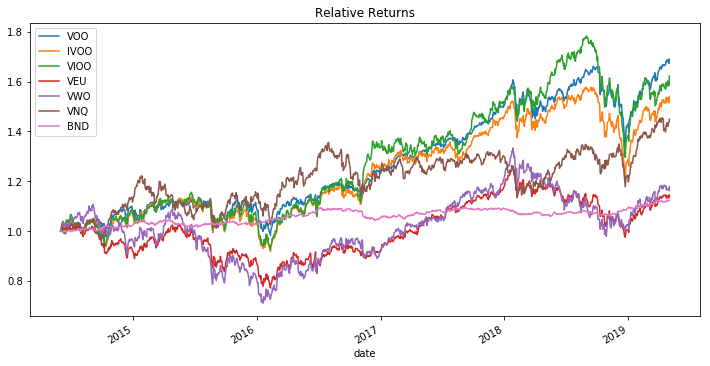

In [12]:
# Normalized Returns
closing_norm = closing / closing.iloc[0,:]
closing_norm.plot(figsize = (12,6))
plt.title("Relative Returns")

## Log Returns vs Arithmetic Returns

[Rreference](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)


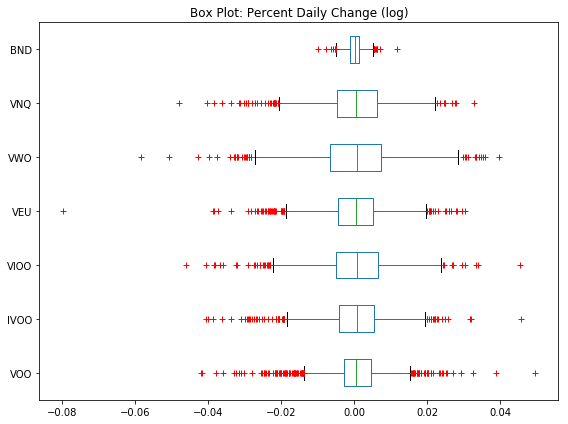

In [13]:
log_ret = np.log(closing.pct_change(1) + 1)
log_ret.plot(kind = 'box', sym='r+', vert=False, figsize = (8,6))
plt.title("Box Plot: Percent Daily Change (log)")
plt.tight_layout()

In [14]:
log_ret.describe()

,VOO,IVOO,VIOO,VEU,VWO,VNQ,BND
count,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000
mean,0.000423,0.000349,0.000391,0.000109,0.000132,0.000299,0.000093
std,0.008423,0.008894,0.009927,0.009116,0.011623,0.009296,0.001963
min,-0.041944,-0.040544,-0.045961,-0.079708,-0.058304,-0.047946,-0.009939
25%,-0.002814,-0.004188,-0.005125,-0.004420,-0.006748,-0.004635,-0.001203
50%,0.000524,0.000679,0.000635,0.000450,0.000693,0.000493,0.000123
75%,0.004501,0.005423,0.006511,0.005257,0.007287,0.006124,0.001337
max,0.049350,0.045627,0.045393,0.030368,0.039492,0.032907,0.011841


# Portfolio Optimization 

In [15]:
class portOpt:
    def __init__ (self, arStocks, arMyAlloc = np.nan, arNumSims = 10000, arLeverage = False):
        # Stock information
        self.stocks = arStocks
        self.stock_names = arStocks.columns
        self.log_returns = np.log(arStocks.pct_change(1) + 1)
        self.num_stocks = arStocks.shape[1]
        self.my_alloc = pd.Series(arMyAlloc, index=self.stock_names)
               
        # For Monte Carlo Simulations
        self.numSims = arNumSims
        self.all_weights = np.zeros((arNumSims,self.num_stocks))
        self.returns_mat = np.zeros(arNumSims)
        self.vol_mat = np.zeros(arNumSims)
        self.SR_mat = np.zeros(arNumSims)
        
        # For capturing perfromance of maximum Sharpe Ratio allocation
        self.maxSR = np.nan
        self.maxSRWeights = np.zeros((1,arStocks.shape[1]))
        self.maxSharpeReturns = np.nan
        self.maxSharpeVolatility = np.nan
        
        # For capturing perfromance of my portfolio
        self.getMyPortPerf()
        
        # For capturing perfromance of portfolio with custom volatility but max returns
        self.cur_max_possible_returns = np.nan
        self.customVol = np.nan
        self.cur_max_possible_returns_SR = np.nan
        self.cur_max_possible_returns_weights = np.zeros((1,arStocks.shape[1]))
        
        # For optimization based efficient frontier
        if (arLeverage == True):
            # -1 to +1 bounds for each weight (with leverage)
            # TODO: Need to check if this works
            seld.bounds = [(-1,1) for i in range(self.num_stocks)]
        elif (arLeverage == False):
            # 0-1 bounds for each weight (no leverage)
            self.bounds = [(0,1) for i in range(self.num_stocks)]
        else:
            sys.exit("arLeverage must be either 'True' or 'False'. You entered '{}'.".format(arLeverage))
               
        self.init_guess = [1/self.num_stocks for i in range(self.num_stocks)]
        
        self.frontier_volatility = []
        self.frontier_returns = []
                             
    def setNumSums (self, arNumSims = 10000):
        self.numSims = arNumSims
        self.all_weights = np.zeros((arNumSims,arStocks.shape[1]))
        self.returns_mat = np.zeros(arNumSims)
        self.vol_mat = np.zeros(arNumSims)
        self.SR_mat = np.zeros(arNumSims)
                    
    def simulateEffFrontier(self, arVerbose = False):
        for ind in range(self.numSims):
            # Create Random Weights that add upto 1
            weights = np.array(np.random.random(self.stocks.shape[1]))
            weights = weights / np.sum(weights)

            self.all_weights[ind,:] = weights # Save Weights
            self.returns_mat[ind] = np.sum((self.log_returns.mean() * weights) *252) # Expected Return
            self.vol_mat[ind] = np.sqrt(np.dot(weights.T, np.dot(self.log_returns.cov() * 252, weights))) # Expected Variance
            self.SR_mat[ind] = self.returns_mat[ind]/self.vol_mat[ind] # Sharpe Ratio
            
        self.maxSR = np.round(self.SR_mat.max(),2)
        self.maxSharpeReturns = np.round(self.returns_mat[self.SR_mat.argmax()],4)
        self.maxSharpeVolatility = np.round(self.vol_mat[self.SR_mat.argmax()],4)
        
        self.setMaxSRWeights(arWeights=pd.Series(self.all_weights[self.SR_mat.argmax(),:]))
               
        if (arVerbose == True):
            print (self.getMaxSRPortPerf())
            print ("============================")
            print (self.getBestWeights())
            
    def getMaxSharpeRatio(self):
        return(self.maxSR)
          
    def getMaxSharpeReturns(self):
        return(self.maxSharpeReturns)
    
    def getMaxSharpeVolatility(self):
        return(self.maxSharpeVolatility)
   
    def setMaxSRWeights(self,arWeights):
        self.maxSRWeights= np.round(pd.Series(arWeights),4)
        self.maxSRWeights.index = self.stock_names
    
    def getBestWeights(self):
        return(self.maxSRWeights)
    
    def getMaxSRPortPerf(self):
        return(pd.Series({'Sharpe Ratio':np.round(self.maxSR,2)
                         ,'Returns':np.round(self.maxSharpeReturns,4)*100
                         ,'Volatility':np.round(self.maxSharpeVolatility,4)*100}
                        ))
    
    def getMyPortPerf(self):
        self.myReturns, self.myVolatility, self.mySR  = self.get_ret_vol_sr(self.my_alloc)
        return(pd.Series({'Sharpe Ratio':np.round(self.mySR,2)
                         ,'Returns':np.round(self.myReturns,4)*100
                         ,'Volatility':np.round(self.myVolatility,4)*100}
                        ))
    
    def getCurVolBestReturnsPerf(self):
        self.myReturns, self.myVolatility, self.mySR  = self.get_ret_vol_sr(self.my_alloc)
        return(pd.Series({'Sharpe Ratio':np.round(self.cur_max_possible_returns_SR,2)
                         ,'Returns':np.round(self.cur_max_possible_returns,4)*100
                         ,'Volatility':np.round(self.customVol,4)*100}
                        ))
    def getAllPerf(self, arVerbose = False):
        df = pd.DataFrame({"Best Sharpe":self.getMaxSRPortPerf()
                          ,"Current":self.getMyPortPerf()
                          ,"Custom Vol, Eff Frontier":self.getCurVolBestReturnsPerf()})
        
        if (arVerbose == True):
            print (df)
            
        return(df)
    
    def getAllWeights(self, arVerbose = False):
        d = {'Best Sharpe': np.round(self.maxSRWeights,4)*100 
             ,'Current': np.round(self.my_alloc,4)*100
             ,'Custom Vol, Eff Frontier': np.round(self.cur_max_possible_returns_weights,4)*100
            }
        
        df = pd.DataFrame(d)
        if (arVerbose == True):
            print (df)
        
        return (df)
      
    def plotEffFrontier(self):
        # Plotting the data
        plt.figure(figsize=(12,8))
        plt.scatter(self.vol_mat, self.returns_mat,c=self.SR_mat,cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')

        # Mark portfolio with max SR
        if ((~np.isnan(self.maxSharpeVolatility)) & (~np.isnan(self.maxSharpeReturns))):
            plt.scatter(self.maxSharpeVolatility,self.maxSharpeReturns
                        ,marker='*',c='green',s=200,edgecolors='black',label="Max Sharpe")
        
        # Plot Efficient Frontier 
        plt.plot(self.frontier_volatility,self.frontier_returns
                 ,'g--',linewidth=3, label="Efficient Frontier") # Add frontier line
        
        # Mark My Portfolio
        if ((~np.isnan(self.myVolatility)) & (~np.isnan(self.myReturns))):
            plt.scatter(self.myVolatility,self.myReturns
                        ,marker='X',c='red',s=200,edgecolors='black',label="Current Returns")        
        
        # Plot Best portfolio with Current Volatility 
        if ((~np.isnan(self.myVolatility)) & (~np.isnan(self.cur_max_possible_returns))):
            plt.scatter(self.customVol,self.cur_max_possible_returns
                        ,marker='D',c='blue',s=100,edgecolors='black',label="Best Ret - Selected Vol.") 
            
        plt.legend()
        
    def get_ret_vol_sr(self,weights):
        """
        Takes in weights, returns array or return,volatility, sharpe ratio
        """
        weights = np.array(weights)
        ret = np.sum(self.log_returns.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T, np.dot(self.log_returns.cov() * 252, weights)))
        sr = ret/vol
        return np.array([ret,vol,sr])

    def maximize_sharpe(self,weights):
        return  self.get_ret_vol_sr(weights)[2] * (-1)
    
    def minimize_volatility(self, weights):
        return  self.get_ret_vol_sr(weights)[1] 

    def maximize_returns(self, weights):
        return  self.get_ret_vol_sr(weights)[0] * (-1)
    
    # Contraints
    def check_sum(self,weights):
        """
        Returns 0 if sum of weights is 1.0
        """
        return np.sum(weights) - 1
    
    def optimizePort(self, arLeverage = False):
        # By convention of minimize function it should be a function that returns zero for conditions
        cons = ({'type':'eq','fun': self.check_sum})
        
        # Sequential Least Squares Programming (SLSQP).
        opt_results = minimize(self.maximize_sharpe
                               ,self.init_guess
                               ,method='SLSQP'
                               ,bounds=self.bounds
                               ,constraints=cons)
        
        self.setMaxSRWeights(arWeights=opt_results.x)
        self.maxSharpeReturns, self.maxSharpeVolatility, self.maxSR = self.get_ret_vol_sr(opt_results.x)
        
    def calculateFrontierFromReturns(self, arMinReturns = 0, arMaxReturns = 0.15, arSteps = 100):
        self.frontier_returns = np.linspace(arMinReturns,arMaxReturns,arSteps) 
        self.frontier_volatility = [] # reset

        for possible_return in self.frontier_returns:
            # function for return
            cons = ({'type':'eq','fun': self.check_sum},
                    {'type':'eq','fun': lambda w: self.get_ret_vol_sr(w)[0] - possible_return})

            result = minimize(self.minimize_volatility
                              ,self.init_guess
                              ,method='SLSQP'
                              ,bounds=self.bounds
                              ,constraints=cons)

            self.frontier_volatility.append(result['fun'])
            
    def calculateFrontierFromVolatility(self, arMinVolatility = 0, arMaxVolatility = 0.15, arSteps = 100):
        self.frontier_volatility = np.linspace(arMinVolatility,arMaxVolatility,arSteps) 
        self.frontier_returns = [] # reset

        for possible_volatility in self.frontier_volatility:
            # function for return
            cons = ({'type':'eq','fun': self.check_sum},
                    {'type':'eq','fun': lambda w: self.get_ret_vol_sr(w)[1] - possible_volatility})

            result = minimize(self.maximize_returns
                              ,self.init_guess
                              ,method='SLSQP'
                              ,bounds=self.bounds
                              ,constraints=cons)

            self.frontier_returns.append(-result['fun']) # negative since we are minimizing the following  (-1 * returns_
    
    def getMaxReturnsForMyVolatility(self, arMyVolatility = np.nan, arVerbose = False):
        # If nothing it mentioned, it will try to take the volatility of your current portfolio
        if (np.isnan(arMyVolatility)):
            if (np.isnan(self.myVolatility)):
                sys.exit("You have not entered a volatility and have not calculated the volatility of your exising portfolio yet. Please do one of the above before proceeding")
            self.customVol = self.myVolatility
        else:
            self.customVol = arMyVolatility
            
        # function for return
        cons = ({'type':'eq','fun': self.check_sum},
                {'type':'eq','fun': lambda w: self.get_ret_vol_sr(w)[1] - self.customVol})

        result = minimize(self.maximize_returns
                          ,self.init_guess
                          ,method='SLSQP'
                          ,bounds=self.bounds
                          ,constraints=cons)

        self.cur_max_possible_returns = np.round(-result['fun'],4) # negative since we are minimizing the following  (-1 * returns_
        self.cur_max_possible_returns_weights = pd.Series(np.round(result.x,4), index=self.stock_names)
        self.cur_max_possible_returns_SR = np.round(self.get_ret_vol_sr(self.cur_max_possible_returns_weights)[2],2)
        
        
        if (arVerbose == True):
            print ("Max possible returns for current volatility: {}".format(self.cur_max_possible_returns))
            print ("============================")
            print (self.cur_max_possible_returns_weights)
        
        return[self.cur_max_possible_returns, self.cur_max_possible_returns_weights]      


In [16]:
my_alloc = [0.377,0.094,0.094,0.126,0.062,0.047,0.20]
# my_alloc = [1,0,0,0,0,0,0] # all US large cap
# my_alloc = [0,0,0,0,0,0,1.0] # all bond
eff_port = portOpt(arStocks=closing,arNumSims=10000,arMyAlloc = my_alloc)

## Efficient Frontier using Monte Carlo Simulations

In [17]:
eff_port.getMyPortPerf()

Sharpe Ratio     0.69
Returns          7.15
Volatility      10.41
dtype: float64

In [18]:
eff_port.simulateEffFrontier()

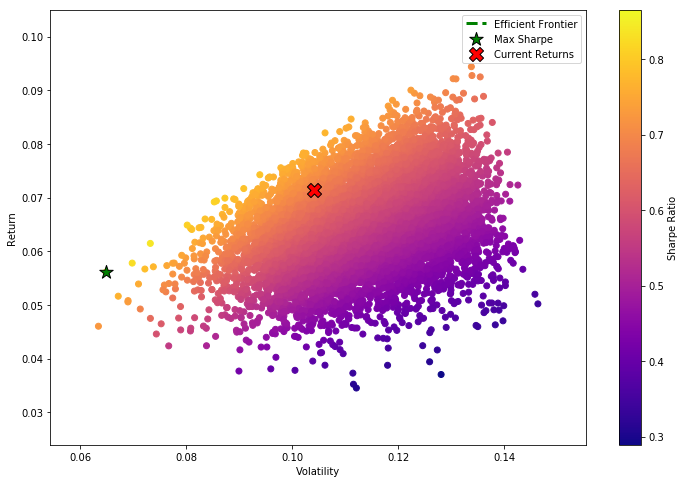

In [19]:
eff_port.plotEffFrontier()

## Efficient Frontier using Optimization

In [20]:
eff_port.optimizePort()
eff_port.getMaxSRPortPerf()

Sharpe Ratio    1.25
Returns         3.95
Volatility      3.17
dtype: float64

### Plotting Efficient Frontier

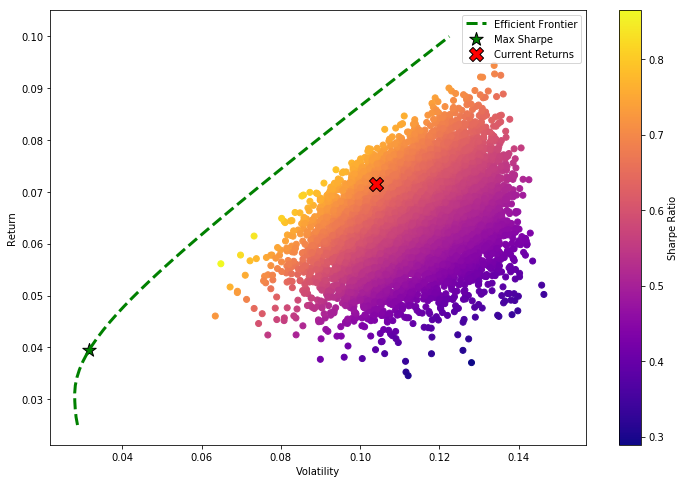

In [21]:
# Method 1: Using Return Range
eff_port.calculateFrontierFromReturns(arMinReturns = 0.025, arMaxReturns = 0.10, arSteps = 50)
eff_port.plotEffFrontier()

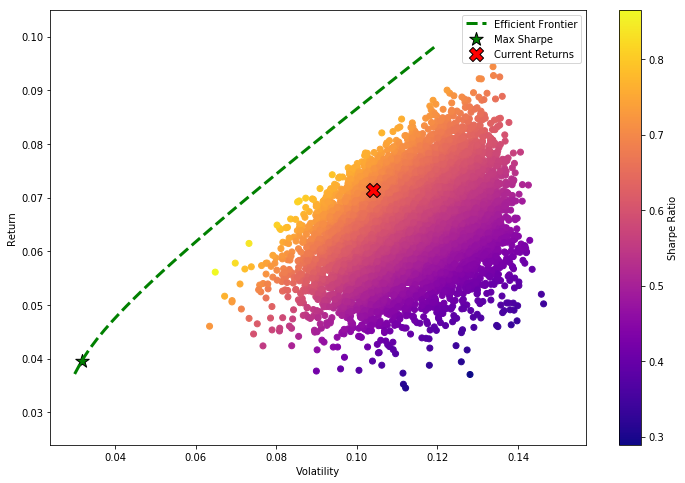

In [22]:
# Alternate method using volatility
eff_port.calculateFrontierFromVolatility(arMinVolatility= 0.03, arMaxVolatility= 0.12, arSteps = 50)
eff_port.plotEffFrontier()

### Compute Max Returns for current portfolio volatity

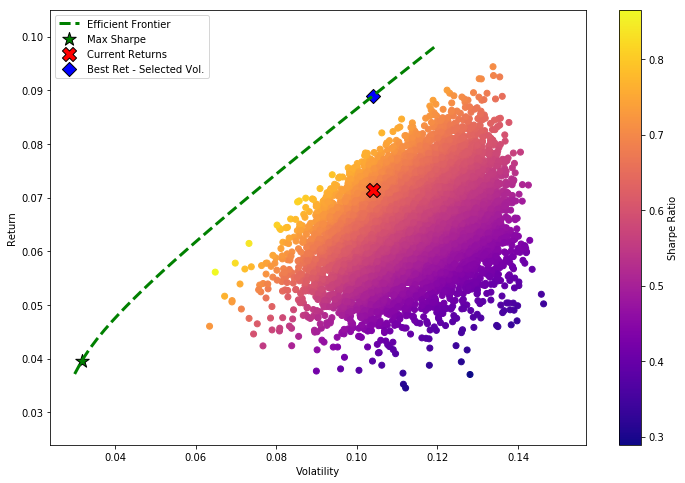

In [23]:
eff_port.getMaxReturnsForMyVolatility()
eff_port.plotEffFrontier()

In [24]:
eff_port.getAllWeights()

,Best Sharpe,Current,"Custom Vol, Eff Frontier"
VOO,18.08,37.7,78.81
IVOO,0.00,9.4,0.00
VIOO,1.28,9.4,0.00
VEU,0.00,12.6,0.00
VWO,0.00,6.2,0.00
VNQ,0.00,4.7,0.00
BND,80.63,20.0,21.19


In [25]:
eff_port.getAllPerf()

,Best Sharpe,Current,"Custom Vol, Eff Frontier"
Sharpe Ratio,1.25,0.69,0.86
Returns,3.95,7.15,8.90
Volatility,3.17,10.41,10.41


### Compute performance at a custom volatility

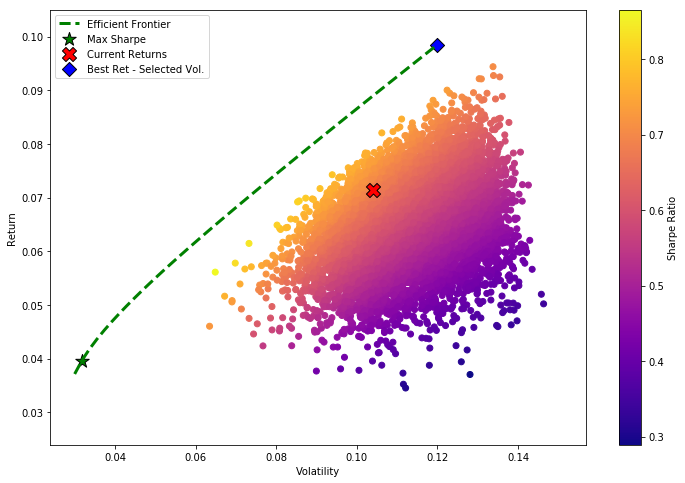

In [26]:
eff_port.getMaxReturnsForMyVolatility(arMyVolatility=0.12,arVerbose=False)
eff_port.plotEffFrontier()

In [27]:
eff_port.getAllWeights()

,Best Sharpe,Current,"Custom Vol, Eff Frontier"
VOO,18.08,37.7,90.22
IVOO,0.00,9.4,0.00
VIOO,1.28,9.4,0.00
VEU,0.00,12.6,0.00
VWO,0.00,6.2,0.00
VNQ,0.00,4.7,0.00
BND,80.63,20.0,9.78


In [28]:
eff_port.getAllPerf()

,Best Sharpe,Current,"Custom Vol, Eff Frontier"
Sharpe Ratio,1.25,0.69,0.82
Returns,3.95,7.15,9.85
Volatility,3.17,10.41,12.00


# Important Note

* **The efficient frontier above is based on the last 5 years performance only (limitation of datareader API).**
* **However in this time, the US large cap has outperformed almost every other investment (normalized for volatility).** 
* **Hence the efficient frontier is skewed predominantly towards US large cap stocks.** 

Text(0.5, 1.0, 'Mean / Standard Deviation: Percent Daily Change')

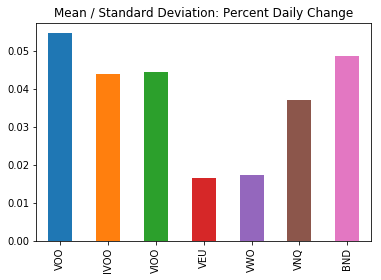

In [29]:
(closing.pct_change(1).mean()/closing.pct_change(1).std()).plot(kind = 'bar')
plt.title("Mean / Standard Deviation: Percent Daily Change")

### To get a better assessment, we need to pull stock data going back much longer to get a more realiatic picture of the efficient frontier

# Using PyPfOpt library

In [30]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(closing)
cov = risk_models.sample_cov(closing)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, cov)
raw_weights = ef.max_sharpe() # Many decimal places
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

{'VOO': 0.37525, 'IVOO': 0.0, 'VIOO': 0.0, 'VEU': 0.0, 'VWO': 0.0, 'VNQ': 0.0, 'BND': 0.62475}
Expected annual return: 5.8%
Annual volatility: 5.0%
Sharpe Ratio: 0.77


(0.05839729598977643, 0.04955594693116636, 0.7748272077841757)